<a href="https://colab.research.google.com/github/Evelyn881025/2025_Agent_club/blob/main/R4/R4_Planning_HW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 非程式題

1. 如果 Agent 沒有 planning 能力會有什麼缺點？

2. planning 在實務應用上會碰到什麼困難？

# 程式題

In [ ]:
!pip install --quiet -U langgraph langchain-openai langchain-community tavily-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.7/143.7 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.4/70.4 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 77.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.1/50.1 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.2/45.2 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.5/216.5 kB 16.4 MB/s eta 0:00:00


## 將下列的小工具加進你的 plan-and-execute agent 裡面，使得輸出類似的結果

> 小小 hint：tutorial 照摳就好好🙂，或是大家可以自己寫一些 function 或是找一些外部 api 工具，玩一下看看有什麼新花樣

In [ ]:
import os
from google.colab import userdata

os.environ["OPENAI_API_KEY"] = userdata.get('OPENAI_API_KEY')
os.environ["TAVILY_API_KEY"] = userdata.get('TAVILY_API_KEY')

| 工具名稱             | 功能                                                    |
|----------------------|---------------------------------------------------------|
| `TavilySearchResults` | 透過 Tavily API 搜尋最多 3 筆最新網頁或新聞              |
| `getMainBuyAndSale`   | 爬取 PChome 股市網站上的台積電報價表格資訊              |


In [ ]:
import requests
import pandas as pd
from langchain_core.tools import tool
from langchain_community.tools.tavily_search import TavilySearchResults
@tool
def getMainBuyAndSale() :
  """台積電股價及其他相關資訊"""
  url = f'https://pchome.megatime.com.tw/stock/sto1/ock4/sid' + '2330' + '.html'
  payloads = {'is_check': '1'}
  resp = requests.request(method='POST', url=url, data=payloads)
  data = pd.read_html(resp.text)

  return data[0].to_string(index=False)

tools = [
    TavilySearchResults(max_results=3),
    getMainBuyAndSale
    ]

In [ ]:
from langchain_openai import ChatOpenAI
from langgraph.prebuilt import create_react_agent

# Choose the LLM that will drive the agent
llm = ChatOpenAI(
    model="gpt-4o-mini-2024-07-18",
    temperature=0
    )

prompt = "你是一個專業等級的任務執行器，用來完美執行任務計劃。"
agent_executor = create_react_agent(
    llm,
    tools,
    prompt=prompt,
    # debug=True
    )

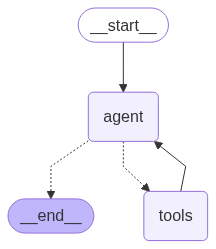

In [ ]:
from IPython.display import Image, display

display(Image(agent_executor.get_graph(xray=True).draw_mermaid_png()))


In [ ]:
import operator
from typing import Annotated, List, Tuple
from typing_extensions import TypedDict


class PlanExecute(TypedDict):
    input: str
    plan: List[str] # 待執行的步驟
    past_steps: Annotated[List[Tuple], operator.add] # 執行步驟後的結果
    response: str # 最終的問題回覆結果

In [ ]:
from langchain_core.prompts import ChatPromptTemplate
from pydantic import BaseModel, Field

class Plan(BaseModel):
    """未來要遵循的計劃"""

    steps: List[str] = Field(description="不同的步驟，應按順序排列")

planner_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """
            你是一個專業等級的任務規劃器。
            請根據指定目標，擬定一份簡潔的逐步執行計畫。
            此計畫應包含一系列獨立的任務，每個任務若正確執行，將逐步導向正確的答案。
            請避免加入任何多餘的步驟。
            最終步驟的執行結果即為最終答案。
            請確保每個步驟皆包含完成所需的所有資訊，不得跳過任何必要步驟。
            """,
        ),
        ("placeholder", "{messages}"),
    ]
)

In [ ]:

planner = planner_prompt | ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0
).with_structured_output(Plan)


In [ ]:
planner.invoke(
    {
        "messages": [
            ("user", "今天適合將新台幣兌換成日圓嗎？只根據今天日期及今天過去30天的平均匯率做判斷。")
        ]
    }
)

Plan(steps=['查詢今天的日期。', '查詢今天的台幣兌日圓匯率。', '查詢過去30天的台幣兌日圓匯率數據。', '計算過去30天的平均匯率。', '比較今天的匯率與過去30天的平均匯率。', '如果今天的匯率低於平均匯率，則適合兌換；如果高於平均匯率，則不適合兌換。'])

In [ ]:
from typing import Union


class Response(BaseModel):
    """回應使用者的內容"""

    response: str


class Act(BaseModel):
    """要執行的動作"""

    action: Union[Response, Plan] = Field(
        description="要執行的動作： 若要回應使用者，請使用'Response'。"
        "若需進一步使用工具以取得答案，請使用'Plan'。"
    )

replanner_prompt = ChatPromptTemplate.from_template(
    """
    你是一個專業等級的任務規劃器，負責根據任務目標、已完成步驟與原始計畫，調整剩餘的執行計畫。

    請根據本次任務目標，擬定一份簡潔、有效率的執行計畫。計畫應包含一系列明確且獨立的步驟，每個步驟皆可由代理人執行，且能逐步導向正確的最終答案。

    **請遵循以下規則：**
    - 僅列出尚未完成且仍需執行的步驟。
    - 不得重複列出已執行的步驟，特別是最近已完成過一次以上的項目。
    - 每個步驟應包含完成任務所需的所有資訊，不能跳過必要內容。
    - 若你已取得足夠資訊，能直接做出最終判斷，請直接使用 `Response` 回覆使用者，而非重新規劃 `Plan`。
    - 若仍需進一步執行工具或分析資料，請僅補上剩餘計畫。

    ---

    本次任務目標：
    {input}

    原始計畫：
    {plan}

    已執行的步驟與結果：
    {past_steps}

    請回傳下一步動作（action）：
    - 若可直接回覆使用者，請產出一段明確且完整的 `Response`。
    - 若仍需進一步執行任務，請產出新的 `Plan`（不包含已執行步驟）。

    你應避免讓代理人陷入無限迴圈，請務必依據進度判斷是否該結束流程。
    """
    )


In [ ]:
replanner = replanner_prompt | ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0
).with_structured_output(Act)

In [ ]:
from langgraph.graph import END


# 執行計劃中的第一個步驟
async def execute_step(state: PlanExecute):
    plan = state["plan"]
    # 將所有步驟編號整理成文字（用於提示）
    plan_str = "\n".join(f"{i+1}. {step}" for i, step in enumerate(plan))
    task = plan[0] # 抓出第一個尚未執行的步驟
    task_formatted = f"""針對以下計劃：{plan_str}\n\n你的任務是執行 step {1}, {task}."""

    # 呼叫執行器執行該步驟
    agent_response = await agent_executor.ainvoke(
        {"messages": [("user", task_formatted)]}
    )

    # 回傳本次執行結果（步驟與回應）
    return {
        "past_steps": [(task, agent_response["messages"][-1].content)],
    }

# 初始規劃流程
async def plan_step(state: PlanExecute):
    plan = await planner.ainvoke({"messages": [("user", state["input"])]})
    return {"plan": plan.steps}

# 根據已完成的步驟與整體輸入，更新後續步驟或直接產生答案。
async def replan_step(state: PlanExecute):
    # 將已執行的一個步驟從 plan 中移除
    new_plan = state["plan"][1:]

    # 將更新後的 state 傳入 replanner
    replanner_input = {
        "input": state["input"],
        "plan": new_plan,
        "past_steps": state["past_steps"],
    }
    output = await replanner.ainvoke(replanner_input)

    if isinstance(output.action, Response):
        return {"response": output.action.response}
    else:
        return {"plan": output.action.steps}

# 檢查是否已經產生最終回應，決定是否結束流程
def should_end(state: PlanExecute):
    if "response" in state and state["response"]:
        return END
    else:
        return "executor"

In [ ]:
from langgraph.graph import StateGraph, START

graph_builder = StateGraph(PlanExecute)

graph_builder.add_node("planner", plan_step) # 新增規劃器節點
graph_builder.add_node("executor", execute_step) # 新增執行器節點
graph_builder.add_node("replanner", replan_step) # 新增重新規劃器節點

graph_builder.add_edge(START, "planner")
graph_builder.add_edge("planner", "executor") # 將規劃器與執行器連接
graph_builder.add_edge("executor", "replanner") # 將執行器與重新規劃器連接

graph_builder.add_conditional_edges(
    "replanner",
    should_end,
    ["executor", END],
)

graph = graph_builder.compile()

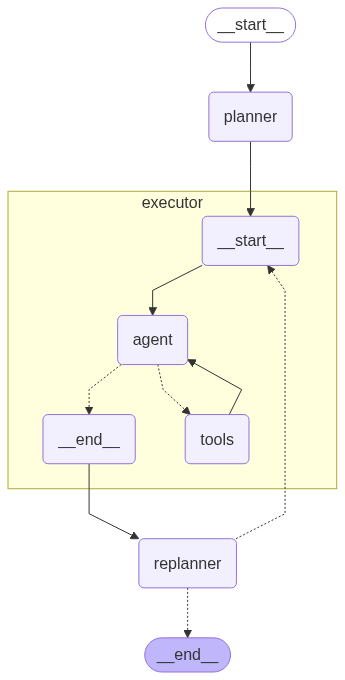

In [ ]:
from IPython.display import Image, display

display(Image(graph.get_graph(xray=True).draw_mermaid_png()))


In [ ]:
from langchain_core.callbacks.base import BaseCallbackHandler

class PrintToolNameHandler(BaseCallbackHandler):
    def on_tool_start(self, serialized_tool: dict, input_str, **kwargs):
        tool_name = serialized_tool.get("name", "")
        print(f"[Tool name] {tool_name}")

In [ ]:
config = {"recursion_limit": 50,
          "callbacks":[PrintToolNameHandler()]}
inputs = {"input": "明天適合進場台積電嗎?"}

async for event in graph.astream(inputs, config=config):
    for k, v in event.items():
        if k != "__end__":
            for step in v.keys():
              if step == "plan":
                print(f"[{step}]")
                for idx, action in enumerate(v[step]):
                  print(f"{idx+1}. {action}")

              elif step == "past_steps":
                print(f"[{step}]")
                for action in v[step][0]:
                  print(action)

              else:
                print(f"[{step}]")
                print(v[step])
    print('\n')

[plan]
1. 查詢台積電的最新股價和市場趨勢。
2. 分析台積電的財報和近期業績表現。
3. 檢視相關新聞和市場分析師的評價。
4. 考慮整體股市的走勢和經濟指標。
5. 根據以上資訊評估進場的風險和潛在收益。
6. 做出是否進場的決策。


[Tool name] getMainBuyAndSale


/tmp/ipython-input-44-2297184055.py:11: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  data = pd.read_html(resp.text)


[past_steps]
查詢台積電的最新股價和市場趨勢。
台積電的最新股價資訊如下：

- **最新股價**: 1060.0
- **漲跌**: -20.0
- **成交張數**: 32,327
- **買價**: 1065.0
- **買量**: 868
- **賣價**: 1075.0
- **賣量**: 303
- **開盤價**: 1080.0
- **最高價**: 1080.0
- **最低價**: 1060.0
- **昨收**: 1080.0

這些數據顯示台積電的股價目前有所下跌，並且成交量相對活躍。接下來可以進行下一步的分析。


[plan]
1. 分析台積電的財報和近期業績表現。
2. 檢視相關新聞和市場分析師的評價。
3. 考慮整體股市的走勢和經濟指標。
4. 根據以上資訊評估進場的風險和潛在收益。
5. 做出是否進場的決策。


[Tool name] getMainBuyAndSale


/tmp/ipython-input-44-2297184055.py:11: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  data = pd.read_html(resp.text)


[past_steps]
分析台積電的財報和近期業績表現。
台積電的近期業績表現如下：

- **漲跌**: -20.0
- **成交張數**: 32,327
- **買價**: 1060.0
- **買量**: 868
- **賣價**: 1065.0
- **賣量**: 303
- **開盤價**: 1075.0
- **最高價**: 1080.0
- **最低價**: 1060.0
- **昨收價**: 1080.0

從這些數據可以看出，台積電的股價在最近一段時間內出現了下跌，並且成交量相對較高，這可能表明市場對其股票的關注度增加。接下來，我們可以進一步分析其財報和業績表現，以獲得更深入的見解。請問您需要我進一步查詢台積電的財報內容嗎？


[plan]
1. 檢視相關新聞和市場分析師的評價。
2. 考慮整體股市的走勢和經濟指標。
3. 根據以上資訊評估進場的風險和潛在收益。
4. 做出是否進場的決策。


[Tool name] tavily_search_results_json
[past_steps]
檢視相關新聞和市場分析師的評價。
以下是關於台積電的最新新聞和市場分析師的評價：

1. **外資在「壓低吃貨」？分析師曝台積電「關鍵價位」**
   - 分析師詹家鴻指出，儘管市場對台積電的前景相對保守，外資機構紛紛下調目標價，包括高盛將台積電目標價從1,400元調整為1,200元；花旗從1,400元下調至1,050元。
   - [閱讀更多](https://tw.stock.yahoo.com/news/%E5%A4%96%E8%B3%87%E5%9C%A8-%E5%A3%93%E4%BD%8E%E5%90%83%E8%B2%A8-%E5%88%86%E6%9E%90%E5%B8%AB%E6%9B%9D%E5%8F%B0%E7%A9%8D%E9%9B%BB-%E9%97%9C%E9%8D%B5%E5%83%B9%E4%BD%8D-%E4%BD%8E%E6%96%BC%E8%A9%B2%E5%83%B9%E4%BD%8D%E5%8F%AF%E7%A9%8D%E6%A5%B5%E8%B2%B7%E5%85%A5-081000018.html)

2. **台積電上榜！外媒推2檔「怪物級」股票未來10年優勢無敵**
   - 分析師認為，即使近期市場波

/tmp/ipython-input-44-2297184055.py:11: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  data = pd.read_html(resp.text)


[past_steps]
根據台積電的最新股價、業績表現、相關新聞及市場分析，評估進場的風險和潛在收益。
### 台積電最新股價及業績表現

1. **股價資訊**:
   - 最新股價: 1060.0 元
   - 最高價: 1080.0 元
   - 最低價: 1060.0 元
   - 成交量: 32327 股

2. **業績表現**:
   - 2025年第一季財報顯示，營收為255.3億美元，同比增長41.6%。
   - 營業利潤為123.8億美元，同比增長56.1%。

### 相關新聞及市場分析

1. **市場預測**:
   - 根據分析，台積電在未來幾年內的EPS（每股盈餘）預測持續增長，2025年預計達到68.23元，2026年79.56元，2027年84.56元。
   - 目前市場對於台積電的評價普遍偏向樂觀，分析師給予的目標價範圍在939元至1575元之間。

2. **行業趨勢**:
   - 台積電在全球半導體市場中佔有超過50%的市場份額，未來幾年隨著AI和5G技術的發展，需求預計將持續增長。
   - 近期的市場分析指出，台積電的業務增長受到全球經濟復甦的推動，特別是在中國市場的需求回暖。

3. **風險因素**:
   - 全球經濟不確定性及供應鏈問題可能影響台積電的生產能力。
   - 競爭對手的技術進步及市場份額的爭奪也可能對台積電造成壓力。

### 風險與潛在收益評估

- **潛在收益**:
  - 隨著業績增長和市場需求的提升，台積電的股價有潛力上漲，尤其是在未來幾年內。
  - 若股價達到分析師的高預測目標（1575元），將帶來顯著的資本利得。

- **風險**:
  - 若全球經濟放緩或供應鏈問題持續，可能會影響台積電的業績表現，導致股價下跌。
  - 競爭加劇可能會壓縮利潤空間，影響未來的股東回報。

### 結論

根據以上分析，台積電在未來幾年內的潛在收益相對較高，但同時也存在一定的風險。投資者需根據自身的風險承受能力和市場動態做出進場決策。


[response]
根據目前的分析，台積電的股價在1060元，近期業績表現良好，並且市場對其長期潛力持樂觀態度。然而，仍需考慮全球經濟不確定性及競爭壓力等風險因素。綜合考量，若您能承受一定的風險，明天進場台積電可能是一個不錯的選擇，特別是長期投資的角度。